<a href="https://colab.research.google.com/github/adriendod/behavioral-cloning/blob/master/Udacity_Simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [45]:
!unzip "/content/gdrive/My Drive/Data Science/Dataset udacity/datazip/Archive.zip" -d "/content/data/"

Archive:  /content/gdrive/My Drive/Data Science/Dataset udacity/datazip/Archive.zip
replace /content/data/IMG/right_2019_09_09_22_11_05_624.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
!pip3 install imgaug
!pip3 install --upgrade scikit-image
!pip3 install tensorboardcolab

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import random
from PIL import Image
from google.colab import files
from tensorboardcolab import *

Using TensorFlow backend.


In [0]:
imagedir = "/content/data/IMG"
df = pd.read_csv("/content/data/driving_log.csv",header=None, names=["center", "left", "right", "steering", "acceleration", "breaking", "speed" ])
df.replace("/Users/adriendodinet/Downloads/beta_simulator_mac", "/content/data", regex=True, inplace=True)

In [90]:
df.iloc[100:110]

,center,left,right,steering,acceleration,breaking,speed
100,/content/data/IMG/center_2019_09_09_21_56_39_9...,/content/data/IMG/left_2019_09_09_21_56_39_958...,/content/data/IMG/right_2019_09_09_21_56_39_95...,-0.016212,1.0,0,30.19031
101,/content/data/IMG/center_2019_09_09_21_56_40_0...,/content/data/IMG/left_2019_09_09_21_56_40_050...,/content/data/IMG/right_2019_09_09_21_56_40_05...,-0.019149,1.0,0,30.19029
102,/content/data/IMG/center_2019_09_09_21_56_40_1...,/content/data/IMG/left_2019_09_09_21_56_40_128...,/content/data/IMG/right_2019_09_09_21_56_40_12...,-0.019149,1.0,0,30.19027
103,/content/data/IMG/center_2019_09_09_21_56_40_2...,/content/data/IMG/left_2019_09_09_21_56_40_201...,/content/data/IMG/right_2019_09_09_21_56_40_20...,-0.019149,1.0,0,30.19027
104,/content/data/IMG/center_2019_09_09_21_56_40_2...,/content/data/IMG/left_2019_09_09_21_56_40_297...,/content/data/IMG/right_2019_09_09_21_56_40_29...,-0.019149,1.0,0,30.19031
105,/content/data/IMG/center_2019_09_09_21_56_40_4...,/content/data/IMG/left_2019_09_09_21_56_40_405...,/content/data/IMG/right_2019_09_09_21_56_40_40...,-0.019149,1.0,0,30.19028
106,/content/data/IMG/center_2019_09_09_21_56_40_5...,/content/data/IMG/left_2019_09_09_21_56_40_512...,/content/data/IMG/right_2019_09_09_21_56_40_51...,-0.019149,1.0,0,30.19027
107,/content/data/IMG/center_2019_09_09_21_56_40_5...,/content/data/IMG/left_2019_09_09_21_56_40_594...,/content/data/IMG/right_2019_09_09_21_56_40_59...,-0.019149,1.0,0,30.19028
108,/content/data/IMG/center_2019_09_09_21_56_40_6...,/content/data/IMG/left_2019_09_09_21_56_40_671...,/content/data/IMG/right_2019_09_09_21_56_40_67...,-0.019149,1.0,0,30.19027
109,/content/data/IMG/center_2019_09_09_21_56_40_7...,/content/data/IMG/left_2019_09_09_21_56_40_759...,/content/data/IMG/right_2019_09_09_21_56_40_75...,-0.016242,1.0,0,30.19030


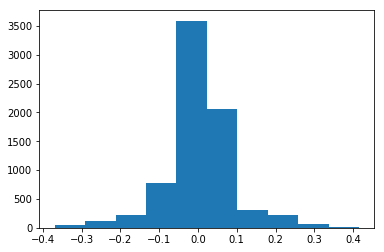

In [53]:
plt.hist(df['steering'])
plt.show()

In [0]:
def load_img(imagedir, df):
  image_path = []
  steering = []
  for i in range(len(df)):
    indexed_data = df.iloc[i]
    image = indexed_data[0]
    image_path.append(os.path.join(imagedir, image.strip()))
    steering.append(indexed_data[3])
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings
  
image_paths, steerings = load_img(imagedir, df)
    

In [61]:
image = image_paths[100]
original_image = mpimg.imread(image)
original_image.shape

(160, 320, 3)

In [0]:
def img_preprocess(img):
  img = mpimg.imread(img)
  img = img[60:140, :,: ]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3,3), 0)
  #img = cv2.resize(img, (200,66))
  img = img/255
  return img

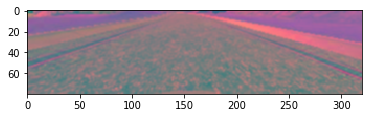

In [81]:
img = img_preprocess(image_paths[100])
plt.imshow(img)

In [82]:
X_train, X_test, y_train, y_test = train_test_split(image_paths, steerings,test_size = 0.2, random_state = 42)
print('Training Samples: {}\nTest Samples: {}'.format(len(X_train), len(X_test)))

Training Samples: 5916
Test Samples: 1479


In [92]:
print(y_train)

[ 0.0204711   0.01351034  0.09988839 ...  0.02202773 -0.1795406
 -0.1078477 ]


Text(0.5, 1.0, 'Preprocessed image')

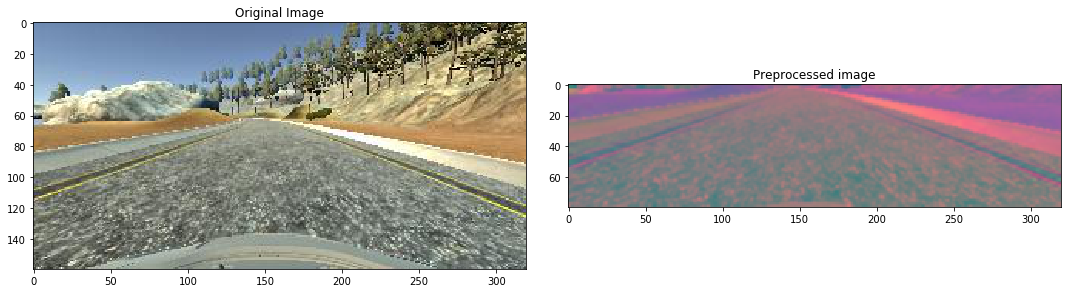

In [83]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)
fig, ax = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()
ax[0].imshow(original_image)
ax[0].set_title("Original Image")
ax[1].imshow(preprocessed_image)
ax[1].set_title("Preprocessed image")

In [0]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_test = np.array(list(map(img_preprocess, X_test)))

0.01380404
(5916, 80, 320, 3)


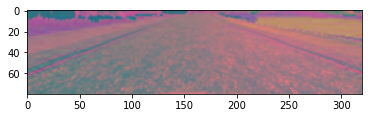

In [85]:
random_number = random.randint(0, len(X_train))
plt.imshow(X_train[random_number])
print (y_train[random_number])
print(X_train.shape)

In [0]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, 5, 5, subsample=(2,2), input_shape = (80, 320, 3), activation='relu'))
  model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation='relu'))
  model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation='relu'))
  model.add(Convolution2D(64, 3, 3, activation='relu'))
  model.add(Convolution2D(64, 3, 3, activation='relu'))
  model.add(Dropout(0.5))
  
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(50, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1))
  
  optimizer = Adam(lr = 1e-4)
  model.compile(loss = 'mse', optimizer=optimizer)
  return model

In [103]:
#tbc=TensorBoardColab()
model = nvidia_model()
print(model.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(80, 320, ..., activation="relu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="relu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="relu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3),

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 38, 158, 24)       1824      
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 17, 77, 36)        21636     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 7, 37, 48)         43248     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 5, 35, 64)         27712     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 3, 33, 64)         36928     
_________________________________________________________________
dropout_9 (Dropout)          (None, 3, 33, 64)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 6336)             

In [104]:
history = model.fit(X_train, y_train, epochs = 10, validation_data = (X_test, y_test), batch_size = 64, verbose = 1, shuffle = 1, callbacks=[TensorBoardColabCallback(tbc)])

Train on 5916 samples, validate on 1479 samples
Epoch 1/10
5916/5916 [==============================] - 10s 2ms/step - loss: 0.0073 - val_loss: 0.0075
Epoch 2/10
5916/5916 [==============================] - 10s 2ms/step - loss: 0.0069 - val_loss: 0.0056
Epoch 3/10
5916/5916 [==============================] - 10s 2ms/step - loss: 0.0041 - val_loss: 0.0019
Epoch 4/10
5916/5916 [==============================] - 10s 2ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 5/10
5916/5916 [==============================] - 10s 2ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 6/10
5916/5916 [==============================] - 9s 2ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 7/10
5916/5916 [==============================] - 9s 2ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 8/10
5916/5916 [==============================] - 9s 2ms/step - loss: 0.0012 - val_loss: 7.8339e-04
Epoch 9/10
5916/5916 [==============================] - 10s 2ms/step - loss: 0.0011 - val_loss: 8.3268e-04
Epoch 10/10
5916/591

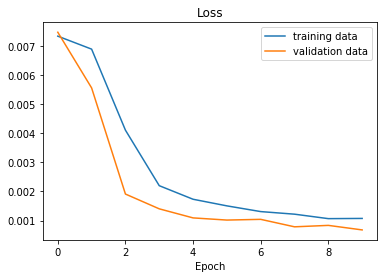

In [105]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training data', 'validation data'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()


In [0]:
model.save('/content/gdrive/My Drive/Data Science/Dataset udacity/model.h5')

In [0]:
"""""files.download('model.h5')"""""

(80, 320, 3)
Prediction:  [[-0.00104639]]
Actual:  -0.09330945


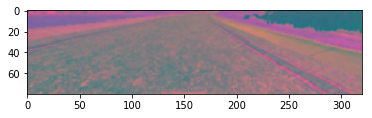

In [120]:
random_number = random.randint(0, len(X_test))
image = X_test[random_number]
print(image.shape)
image = image.reshape(1,80,320,3)
print("Prediction: ", model.predict(image))
print ("Actual: ", y_test[random_number])
plt.imshow(X_test[random_number])
